In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd '/content/drive/MyDrive/COMP-8610/Project'
# %ls

MessageError: Error: credential propagation was unsuccessful

In [1]:
!pip install torch_geometric torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadat

In [12]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import SNRAdam
from SNRAdam import SNRAdam
import torch_optimizer as optim
import pandas as pd

In [8]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Check the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [9]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True


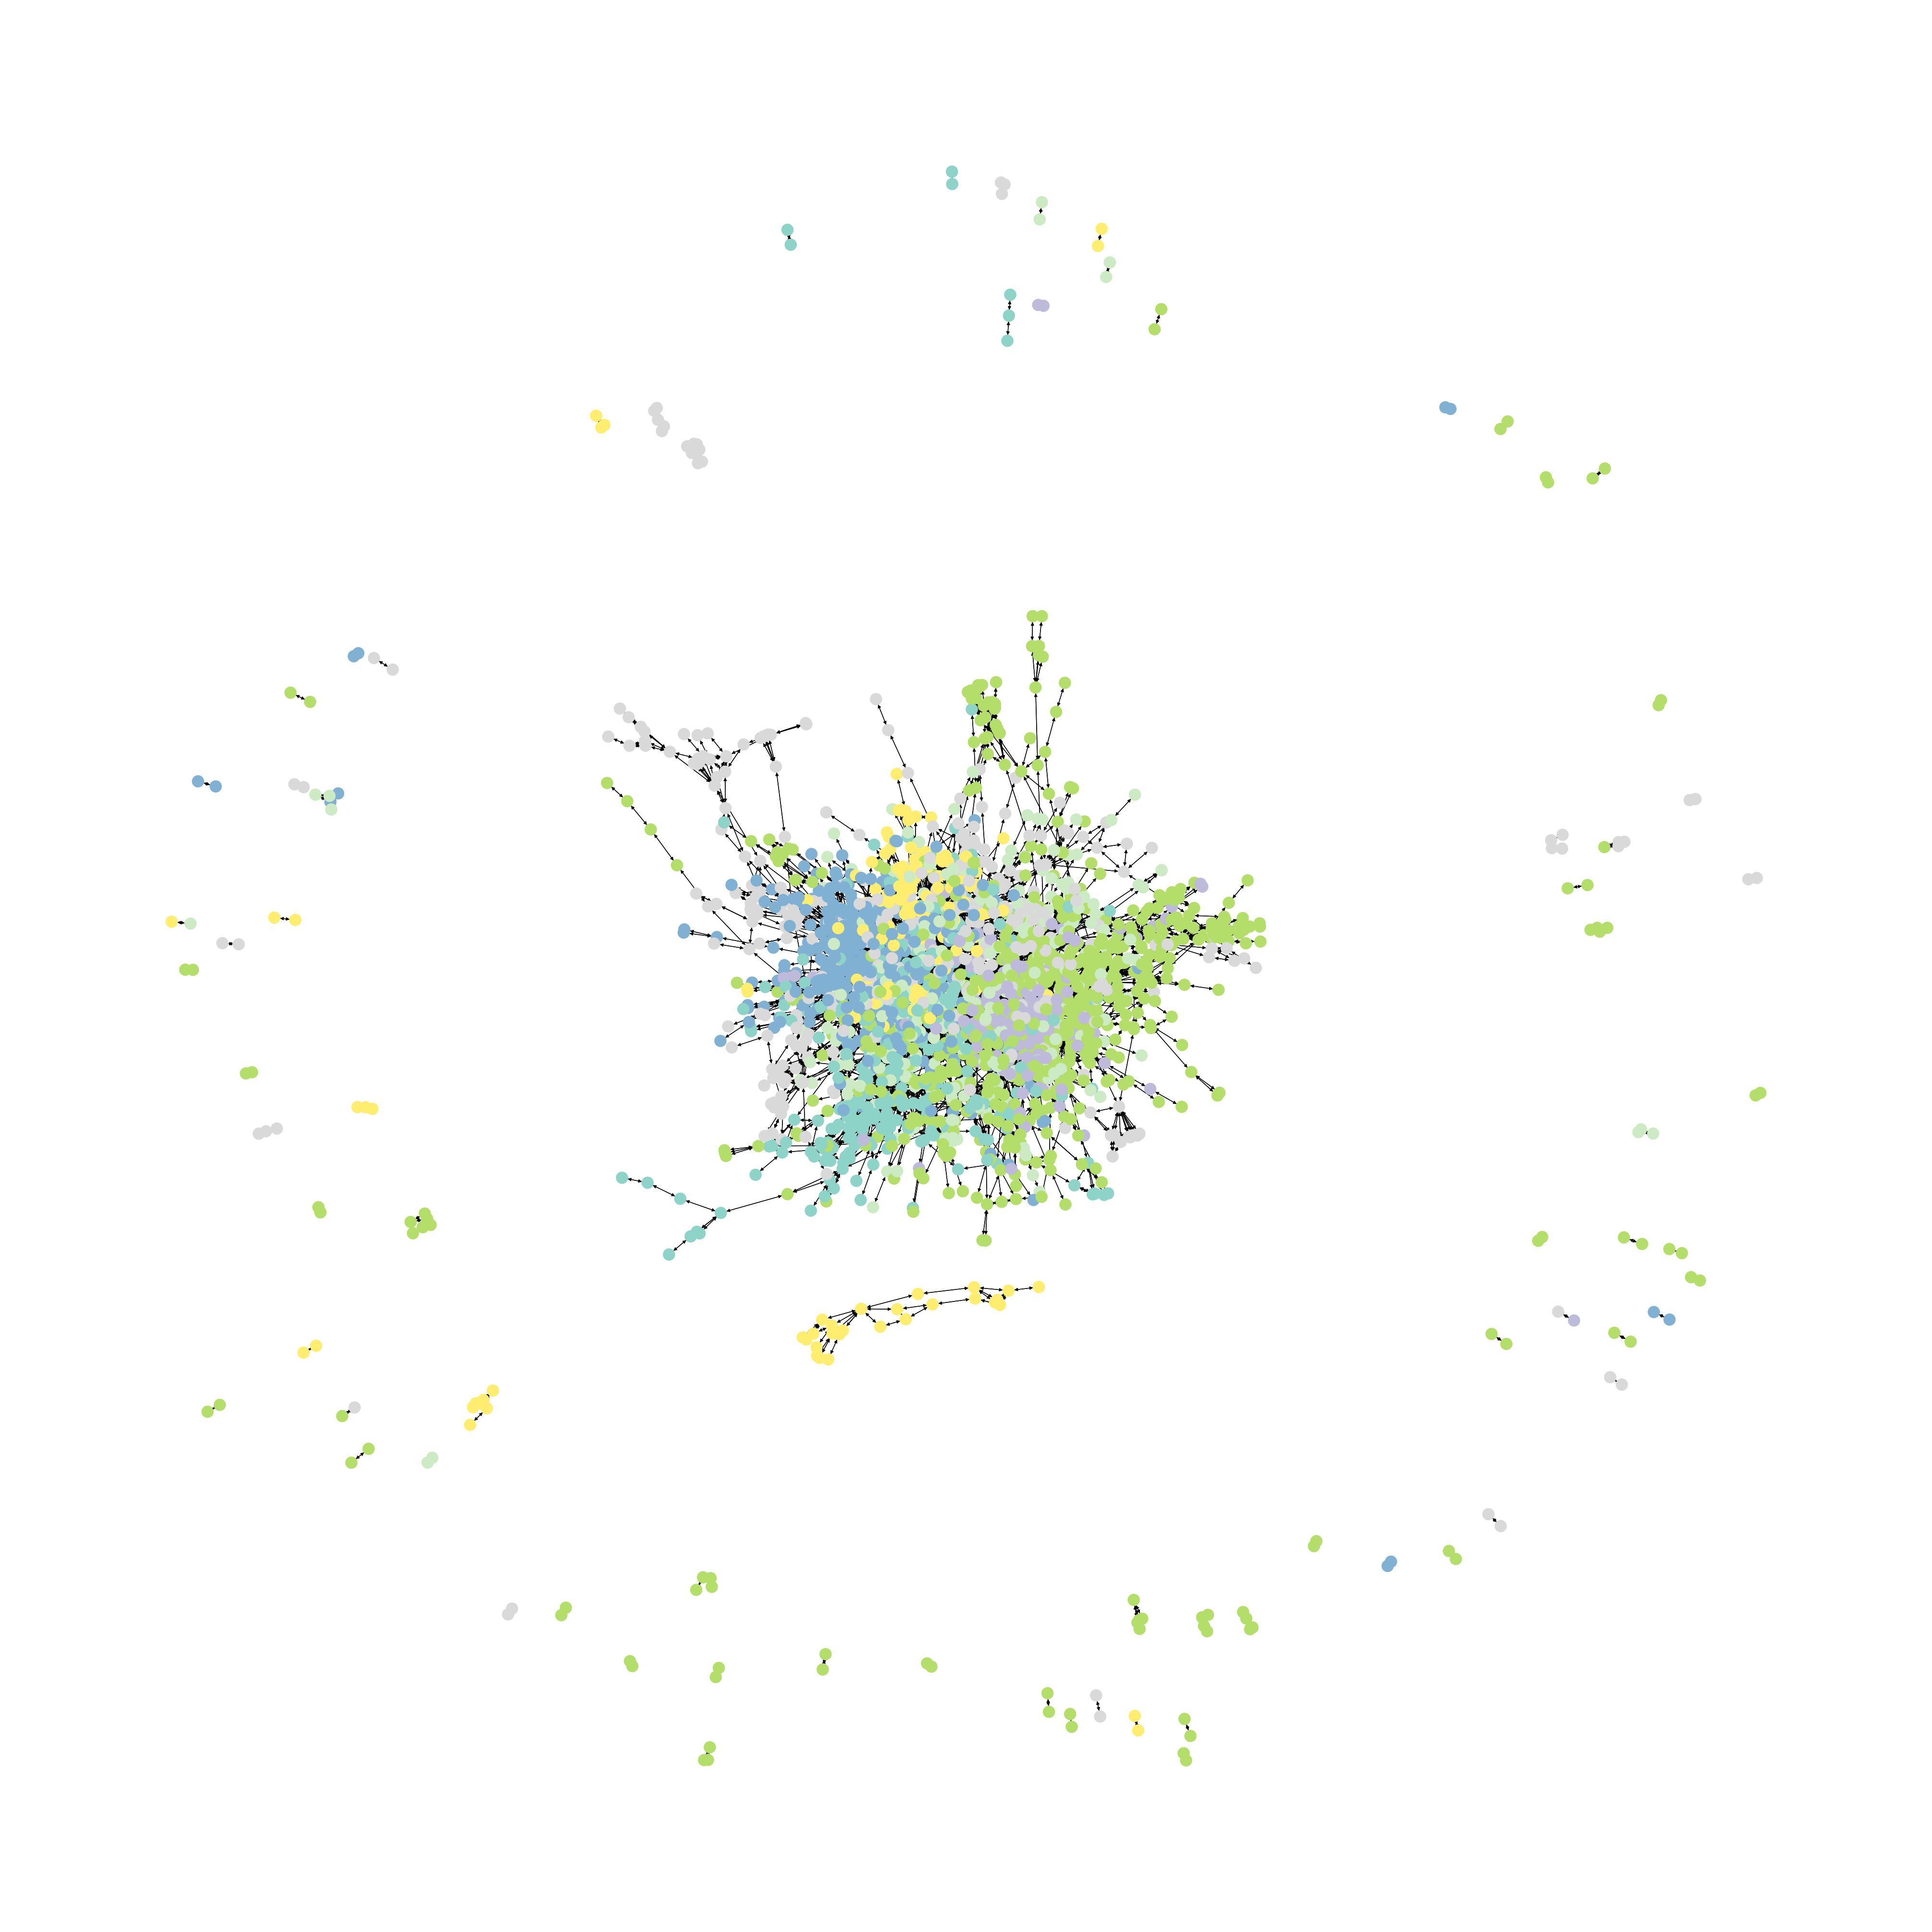

In [6]:
data = dataset[0]
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

plt.figure(figsize=(40, 40))
nx.draw(G, with_labels=False, node_color=data.y, cmap=plt.get_cmap('Set3'))
plt.show()

#GCN

In [46]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 16)
  (conv4): GCNConv(16, 7)
)


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()


# def train_model(model, criterion, optimizer, num_epochs=25):
#     for epoch in range(num_epochs):
#         model.train()

#         optimizer.zero_grad()
#         out = model(data)
#         loss = criterion(out[data.train_mask], data.y[data.train_mask])
#         loss.backward()
#         optimizer.step()

#         model.eval()
#         with torch.no_grad():

#           _, train_pred = model(data).max(dim=1)
#           train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
#           train_acc = train_correct / int(data.train_mask.sum().item())

#           _, val_pred = model(data).max(dim=1)
#           val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#           val_acc = val_correct / int(data.val_mask.sum().item())
#           print(f'Epoch {epoch}/{num_epochs - 1}, '
#                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

#     return model

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# model = train_model(model, criterion, optimizer, num_epochs=25)


In [49]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

            _, train_pred = out.max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())

            _, val_pred = out.max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())

            print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    if early_stopping:
        model.load_state_dict(torch.load('checkpoint.pt'))
    return model

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_acc, val_acc, test_acc

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

results = []

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    results.append({'Optimizer': name, 'Train Accuracy': train_acc, 'Validation Accuracy': val_acc, 'Test Accuracy': test_acc})

results_df = pd.DataFrame(results)
print(results_df)

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0960
Epoch 1/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0960
Epoch 2/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0900
Epoch 3/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0880
Epoch 4/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0900
Epoch 5/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0880
Epoch 6/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0840
Epoch 7/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0880
Epoch 8/199, Training Accuracy: 0.2000, Validation Accuracy: 0.0860
Epoch 9/199, Training Accuracy: 0.1929, Validation Accuracy: 0.0820
Epoch 10/199, Training Accuracy: 0.1571, Validation Accuracy: 0.0760
Early stopping at epoch 10
Train Accuracy: 0.1643, Validation Accuracy: 0.0960, Test Accuracy: 0.0910
-------------------------------

In [10]:
# model.eval()
# _, pred = model(data).max(dim=1)
# correct = int(pred[data.test_mas  k].eq(data.y[data.test_mask]).sum().item())
# acc = correct / int(data.test_mask.sum())
# print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7560


#GAT

In [39]:
# # https://arxiv.org/abs/1710.10903
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv, GCNConv

# class GAT(torch.nn.Module):
#     def __init__(self):
#         super(GAT, self).__init__()
#         self.conv1 = GATConv(dataset.num_node_features, 128, heads=16, dropout=0.3)
#         self.conv2 = GATConv(128 * 16, 64, heads=8, dropout=0.3)
#         self.conv3 = GATConv(64 * 8, 16, heads=4, dropout=0.3)
#         self.conv4 = GATConv(16 * 4, dataset.num_classes, heads=1, concat=False, dropout=0.3)

#         # self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.3)
#         # self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=False, dropout=0.3)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)

#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.elu(x)

#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv3(x, edge_index)
#         x = F.elu(x)

#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv4(x, edge_index)
#         return F.log_softmax(x, dim=1)

# model = GAT()
# print(model)

GAT(
  (conv1): GATConv(1433, 128, heads=16)
  (conv2): GATConv(2048, 64, heads=8)
  (conv3): GATConv(512, 16, heads=4)
  (conv4): GATConv(64, 7, heads=1)
)


In [33]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model = GAT(in_channels=dataset.num_node_features, out_channels=dataset.num_classes).to(device)
# model = model.to(device)
# data = dataset[0].to(device)
# criterion = nn.CrossEntropyLoss()

# def train_model(model, criterion, optimizer, num_epochs=25):
#     for epoch in range(num_epochs):
#         model.train()
#         optimizer.zero_grad()
#         out = model(data)
#         loss = criterion(out[data.train_mask], data.y[data.train_mask])
#         loss.backward()
#         optimizer.step()

#         model.eval()
#         with torch.no_grad():
#           _, train_pred = model(data).max(dim=1)
#           train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
#           train_acc = train_correct / int(data.train_mask.sum().item())

#           _, val_pred = model(data).max(dim=1)
#           val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#           val_acc = val_correct / int(data.val_mask.sum().item())
#           print(f'Epoch {epoch}/{num_epochs - 1}, '
#                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

#     return model

# # Choose the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Train the model
# model = train_model(model, criterion, optimizer, num_epochs=25)

Epoch 0/24, Training Accuracy: 0.6643, Validation Accuracy: 0.4300
Epoch 1/24, Training Accuracy: 0.9214, Validation Accuracy: 0.6780
Epoch 2/24, Training Accuracy: 0.8000, Validation Accuracy: 0.5840
Epoch 3/24, Training Accuracy: 0.9357, Validation Accuracy: 0.7360
Epoch 4/24, Training Accuracy: 0.9714, Validation Accuracy: 0.7880
Epoch 5/24, Training Accuracy: 0.9429, Validation Accuracy: 0.7880
Epoch 6/24, Training Accuracy: 0.9643, Validation Accuracy: 0.7800
Epoch 7/24, Training Accuracy: 0.9714, Validation Accuracy: 0.7500
Epoch 8/24, Training Accuracy: 0.9643, Validation Accuracy: 0.6980
Epoch 9/24, Training Accuracy: 0.9643, Validation Accuracy: 0.7000
Epoch 10/24, Training Accuracy: 0.9714, Validation Accuracy: 0.7520
Epoch 11/24, Training Accuracy: 0.9714, Validation Accuracy: 0.7820
Epoch 12/24, Training Accuracy: 0.9786, Validation Accuracy: 0.7840
Epoch 13/24, Training Accuracy: 0.9857, Validation Accuracy: 0.7900
Epoch 14/24, Training Accuracy: 1.0000, Validation Accurac

In [44]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# data = dataset[0].to(device)
# criterion = nn.CrossEntropyLoss()


# def train_model(model, criterion, optimizer,data, num_epochs=25, early_stopping=None):
#     for epoch in range(num_epochs):
#         model.train()
#         optimizer.zero_grad()
#         out = model(data)
#         loss = criterion(out[data.train_mask], data.y[data.train_mask])
#         loss.backward()
#         if isinstance(optimizer, torch.optim.LBFGS):
#             def closure():
#                 optimizer.zero_grad()
#                 output = model(data)
#                 loss = criterion(output[data.train_mask], data.y[data.train_mask])
#                 loss.backward()
#                 return loss
#             optimizer.step(closure)
#         else:
#             optimizer.step()

#         model.eval()
#         with torch.no_grad():
#           _, train_pred = model(data).max(dim=1)
#           train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
#           train_acc = train_correct / int(data.train_mask.sum().item())

#           _, val_pred = model(data).max(dim=1)
#           val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#           val_acc = val_correct / int(data.val_mask.sum().item())

#           out = model(data)
#           val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

#           print(f'Epoch {epoch}/{num_epochs - 1}, '
#                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

#           if early_stopping:
#               early_stopping(val_loss.item(), model)
#               if early_stopping.early_stop:
#                   print(f'Early stopping at epoch {epoch}')
#                   break

#     if early_stopping:
#         model.load_state_dict(torch.load('checkpoint.pt'))
#     return model


# # def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
# #     for epoch in range(num_epochs):
# #         model.train()
# #         optimizer.zero_grad()
# #         out = model(data)
# #         loss = criterion(out[data.train_mask], data.y[data.train_mask])
# #         loss.backward()
# #         if isinstance(optimizer, torch.optim.LBFGS):
# #             def closure():
# #                 optimizer.zero_grad()
# #                 output = model(data)
# #                 loss = criterion(output[data.train_mask], data.y[data.train_mask])
# #                 loss.backward()
# #                 return loss
# #             optimizer.step(closure)
# #         else:
# #             optimizer.step()

# #         model.eval()
# #         with torch.no_grad():

# #             _, train_pred = model(data).max(dim=1)
# #             train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
# #             train_acc = train_correct / int(data.train_mask.sum().item())

# #             _, val_pred = model(data).max(dim=1)
# #             val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
# #             val_acc = val_correct / int(data.val_mask.sum().item())

# #             out = model(data)
# #             val_loss = criterion(out[data.val_mask], data.y[data.val_mask])


# #             print(f'Epoch {epoch}/{num_epochs - 1}, '
# #                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

# #             if early_stopping:
# #                 early_stopping(val_loss.item(), model)
# #                 if early_stopping.early_stop:
# #                     print(f'Early stopping at epoch {epoch}')
# #                     break

# #     if early_stopping:
# #         model.load_state_dict(torch.load('checkpoint.pt'))
# #     return model


# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Train the model
# # model = train_model(model, criterion, data, optimizer, num_epochs=25)

# def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):
#     early_stopping = EarlyStopping(patience=patience, delta=0.001)
#     model = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

#     model.eval()
#     _, pred = model(data).max(dim=1)
#     correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
#     train_acc = correct / int(data.train_mask.sum())

#     correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#     val_acc = correct / int(data.val_mask.sum())

#     correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
#     test_acc = correct / int(data.test_mask.sum())

#     print(f'Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}')

#     return train_acc, val_acc, test_acc


# # # Set device
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # data = dataset[0].to(device)
# # criterion = nn.CrossEntropyLoss()

# lr = 0.01
# optimizers = {
#     'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
#     'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
#     'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
#     'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
#     'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
#     'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
#     'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
#     'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
#     'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
#     'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
# }

# results = []

# for name, optimizer in optimizers.items():
#     print("-" * 50)
#     print(f"Optimizer: {name}")
#     print("-" * 50)

#     # Reset model weights
#     model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
#     # model = model.to(device)

#     train_acc, val_acc, test_acc = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

#     results.append({'Optimizer': name, 'Train Accuracy': train_acc, 'Validation Accuracy': val_acc, 'Test Accuracy': test_acc})

# results_df = pd.DataFrame(results)
# print(results_df)

In [ ]:
# model.eval()
# _, pred = model(data).max(dim=1)
# correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
# acc = correct / int(data.test_mask.sum())
# print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7370


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 128, heads=16, dropout=0.3)
        self.conv2 = GATConv(128 * 16, 64, heads=8, dropout=0.3)
        self.conv3 = GATConv(64 * 8, 16, heads=4, dropout=0.3)
        self.conv4 = GATConv(16 * 4, dataset.num_classes, heads=1, concat=False, dropout=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            # print(f'Epoch {epoch}/{num_epochs - 1}, '
            #       f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_acc, val_acc, test_acc

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

results = []

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GATConv)) and m.reset_parameters())

    train_acc, val_acc, test_acc = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    results.append({'Optimizer': name, 'Train Accuracy': train_acc, 'Validation Accuracy': val_acc, 'Test Accuracy': test_acc})

results_df = pd.DataFrame(results)
print(results_df)


GAT(
  (conv1): GATConv(1433, 128, heads=16)
  (conv2): GATConv(2048, 64, heads=8)
  (conv3): GATConv(512, 16, heads=4)
  (conv4): GATConv(64, 7, heads=1)
)
--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Early stopping at epoch 11
Train Accuracy: 0.1857, Validation Accuracy: 0.1280, Test Accuracy: 0.1430
--------------------------------------------------
Optimizer: LBFGS
--------------------------------------------------
Early stopping at epoch 15
Train Accuracy: 0.1429, Validation Accuracy: 0.1640, Test Accuracy: 0.1310
--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1560, Test Accuracy: 0.1440
--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Early stopping at epoch 35
Train Accuracy: 1.0000, Validatio

#GraphSAGE

In [50]:
# https://arxiv.org/abs/1706.02216
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            # print(f'Epoch {epoch}/{num_epochs - 1}, '
            #       f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_acc, val_acc, test_acc

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

results = []

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GATConv)) and m.reset_parameters())

    train_acc, val_acc, test_acc = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    results.append({'Optimizer': name, 'Train Accuracy': train_acc, 'Validation Accuracy': val_acc, 'Test Accuracy': test_acc})

results_df = pd.DataFrame(results)
print(results_df)


GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)
--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Early stopping at epoch 26
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030
--------------------------------------------------
Optimizer: LBFGS
--------------------------------------------------
Early stopping at epoch 17
Train Accuracy: 0.1429, Validation Accuracy: 0.1140, Test Accuracy: 0.1030
--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Early stopping at epoch 47
Train Accuracy: 0.9857, Validation Accuracy: 0.7320, Test Accuracy: 0.7330
--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Early stopping at epoch 13
Train Accuracy: 1.

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model = GraphSAGE(in_channels=dataset.num_node_features, out_channels=dataset.num_classes).to(device)
# data = dataset[0].to(device)
# criterion = nn.CrossEntropyLoss()

# # Define the training function
# def train_model(model, criterion, optimizer, num_epochs=25):
#     for epoch in range(num_epochs):
#         model.train()
#         optimizer.zero_grad()
#         out = model(data)
#         loss = criterion(out[data.train_mask], data.y[data.train_mask])
#         loss.backward()
#         optimizer.step()

#         model.eval()
#         with torch.no_grad():
#             # pred = out.argmax(dim=1)  # Get the index of the maximum log-probability
#             # correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
#             # acc = correct / data.val_mask.sum().item()
#             # print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {loss.item():.4f}, Validation Set Accuracy: {acc:.4f}')
#           _, train_pred = model(data).max(dim=1)
#           train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
#           train_acc = train_correct / int(data.train_mask.sum().item())

#           _, val_pred = model(data).max(dim=1)
#           val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#           val_acc = val_correct / int(data.val_mask.sum().item())
#           print(f'Epoch {epoch}/{num_epochs - 1}, '
#                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

#     return model

# # Choose the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# # Train the model
# model = train_model(model, criterion, optimizer, num_epochs=50)

Epoch 0/49, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 1/49, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 2/49, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 3/49, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 4/49, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 5/49, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 6/49, Training Accuracy: 0.4929, Validation Accuracy: 0.3380
Epoch 7/49, Training Accuracy: 0.3214, Validation Accuracy: 0.2400
Epoch 8/49, Training Accuracy: 0.4214, Validation Accuracy: 0.2720
Epoch 9/49, Training Accuracy: 0.5000, Validation Accuracy: 0.4500
Epoch 10/49, Training Accuracy: 0.4786, Validation Accuracy: 0.5020
Epoch 11/49, Training Accuracy: 0.4643, Validation Accuracy: 0.4760
Epoch 12/49, Training Accuracy: 0.4500, Validation Accuracy: 0.4760
Epoch 13/49, Training Accuracy: 0.4071, Validation Accuracy: 0.4440
Epoch 14/49, Training Accuracy: 0.4143, Validation Accurac

In [ ]:
# model.eval()
# _, pred = model(data).max(dim=1)
# correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
# acc = correct / int(data.test_mask.sum())
# print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7370


#GAE

In [ ]:
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, GAE

# class GCNEncoder(torch.nn.Module):
#     def __init__(self):
#         super(GCNEncoder, self).__init__()
#         self.conv1 = GCNConv(dataset.num_features, 32, cached=True)
#         self.conv2 = GCNConv(32, 16, cached=True)

#         # self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
#         # self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

#     def forward(self, x, data_index):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)

#         return self.conv2(x, edge_index)
#         # return F.log_softmax(x, dim=1)

#         # x = self.conv1(x, edge_index).relu()
#         # return self.conv2(x, edge_index)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# out_channels = 16
# num_features = dataset.num_features

# model = GAE(GCNEncoder()).to(device)
# x = data.x.to(device)
# edge_index = data.edge_index.to(device)
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = SNRAdam(model.parameters(), lr=0.01)

# def train():
#     model.train()
#     optimizer.zero_grad()
#     z = model.encode(x, edge_index)
#     loss = model.recon_loss(z, edge_index)
#     loss.backward()
#     optimizer.step()
#     return float(loss)

# epochs = 200
# for epoch in range(1, epochs + 1):
#     loss = train()
#     # print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

# # Save the learned embeddings
# embeddings = model.encode(x, edge_index).detach().cpu()


In [ ]:
# import torch.nn as nn
# import torch.optim as optim

# class NodeClassifier(nn.Module):
#     def __init__(self):
#         super(NodeClassifier, self).__init__()
#         self.linear = nn.Linear(16, dataset.num_classes)

#     def forward(self, x):
#         return F.log_softmax(self.linear(x), dim=1)

# # Use the learned embeddings
# embeddings = embeddings.to(device)
# labels = data.y.to(device)
# train_mask = data.train_mask.to(device)
# val_mask = data.val_mask.to(device)
# test_mask = data.test_mask.to(device)

# # Initialize the classifier
# classifier = NodeClassifier().to(device)
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.Adam(classifier.parameters(), lr=0.01, weight_decay=5e-4)
# optimizer = SNRAdam(classifier.parameters(), lr=0.01)

# def train_classifier():
#     classifier.train()
#     optimizer.zero_grad()
#     out = classifier(embeddings)
#     loss = criterion(out[train_mask], labels[train_mask])
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# def test_classifier(mask):
#     classifier.eval()
#     with torch.no_grad():
#         out = classifier(embeddings)
#         pred = out[mask].max(1)[1]
#         acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
#     return acc

# # Training loop for the classifier
# epochs = 100
# for epoch in range(1, epochs + 1):
#     loss = train_classifier()
#     train_acc = test_classifier(train_mask)
#     val_acc = test_classifier(val_mask)
#     # test_acc = test_classifier(test_mask)
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, '
#           f'Val Acc: {val_acc:.4f}')


Epoch: 001, Train Acc: 0.2071, Val Acc: 0.2760
Epoch: 002, Train Acc: 0.3143, Val Acc: 0.3280
Epoch: 003, Train Acc: 0.3929, Val Acc: 0.3680
Epoch: 004, Train Acc: 0.4643, Val Acc: 0.4140
Epoch: 005, Train Acc: 0.5643, Val Acc: 0.5400
Epoch: 006, Train Acc: 0.6500, Val Acc: 0.5960
Epoch: 007, Train Acc: 0.6929, Val Acc: 0.6300
Epoch: 008, Train Acc: 0.7214, Val Acc: 0.6560
Epoch: 009, Train Acc: 0.7214, Val Acc: 0.6640
Epoch: 010, Train Acc: 0.7429, Val Acc: 0.6660
Epoch: 011, Train Acc: 0.7571, Val Acc: 0.6760
Epoch: 012, Train Acc: 0.7929, Val Acc: 0.6760
Epoch: 013, Train Acc: 0.8000, Val Acc: 0.6780
Epoch: 014, Train Acc: 0.8000, Val Acc: 0.6800
Epoch: 015, Train Acc: 0.8000, Val Acc: 0.6820
Epoch: 016, Train Acc: 0.8000, Val Acc: 0.6840
Epoch: 017, Train Acc: 0.8071, Val Acc: 0.6820
Epoch: 018, Train Acc: 0.8071, Val Acc: 0.6820
Epoch: 019, Train Acc: 0.8071, Val Acc: 0.6840
Epoch: 020, Train Acc: 0.8071, Val Acc: 0.6860
Epoch: 021, Train Acc: 0.8143, Val Acc: 0.6900
Epoch: 022, T

In [ ]:
# print(f'Test Accuracy: {test_classifier(test_mask):.4f}')

Test Accuracy: 0.7420


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
import pandas as pd

class GCNEncoder(nn.Module):
    def __init__(self):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32, cached=True)
        self.conv2 = GCNConv(32, 16, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAE(GCNEncoder()).to(device)
x = data.x.to(device)
edge_index = data.edge_index.to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.encoder.state_dict(), self.path)

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                z = model.encode(data.x, data.edge_index)
                loss = model.recon_loss(z, data.edge_index)
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.edge_index)
            val_loss = model.recon_loss(z, data.edge_index)

            print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    if early_stopping:
        model.encoder.load_state_dict(torch.load(early_stopping.path))
    return model

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        recon_loss = model.recon_loss(z, data.edge_index).item()

    print(f'Reconstruction Loss: {recon_loss:.4f}')
    return recon_loss

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

results = []

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.encoder.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())

    recon_loss = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)
    results.append({'Optimizer': name, 'Reconstruction Loss': recon_loss})

results_df = pd.DataFrame(results)
print(results_df)


--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 1/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 2/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 3/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 4/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 5/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 6/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 7/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 8/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 9/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 10/199, Loss: 1.3862, Validation Loss: 1.3862
Early stopping at epoch 10
Reconstruction Loss: 1.3862
--------------------------------------------------
Optimizer: LBFGS
--------------------------------------------------
Epoch 0/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 1/199, Loss: 1.3862, Validation Loss: 1.3862
Epoch 2/199, Loss: 1.3862, Validation Loss: 